In [5]:
# Core
import pandas as pd
import numpy as np
from pathlib import Path

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_fscore_support, accuracy_score)

# Feature selection
from sklearn.feature_selection import RFE

# Stats & plots
import matplotlib.pyplot as plt

# For multicollinearity (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

CSV_PATH = "Preprocessed ICU data.csv"   # adjust if needed

# Helper to normalize base variable naming: e.g., 'Mean_GCS.x' -> 'GCS'
def normalized_base(colname: str) -> str:
    name = str(colname)
    for pref in ("Mean_", "Min_", "Max_"):
        if name.startswith(pref):
            name = name[len(pref):]
            break
    if "." in name:
        name = name.split(".", 1)[0]
    return name

def find_candidates_for(base: str, df_cols) -> list:
    numeric_cols = [c for c in df_cols if c not in (None, "")]  # filter weird names
    return [c for c in numeric_cols if normalized_base(c).lower() == base.lower()]

def compute_vif(df_num: pd.DataFrame) -> pd.DataFrame:
    """Compute VIF for numeric features (adds constant)."""
    X = sm.add_constant(df_num.values, has_constant='add')
    vif = [variance_inflation_factor(X, i) for i in range(1, X.shape[1])]
    return pd.DataFrame({"feature": df_num.columns, "VIF": vif}).sort_values("VIF", ascending=False)


In [3]:
# 1.1 Load
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

# Target & ICU type selection
TARGET = "In.hospital_death"
assert TARGET in df.columns, f"Target '{TARGET}' not found. Available: {list(df.columns)[:10]}"

# Choose ICU type (None for all; or 2/3/4, etc.)
ICU_TYPE = 4          # <-- set to None to use all ICUs, or 2/3/4 for subset
if ICU_TYPE is not None:
    icu_col = f"ICUType{ICU_TYPE}"
    assert icu_col in df.columns, f"{icu_col} not found."
    df = df[df[icu_col] == 1].copy()
print(f"Rows after ICU filter: {len(df)}")

# 1.2 Drop pure identifiers & all-zero columns
drop_cols = [c for c in ["RecordID"] if c in df.columns]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

# numeric only for modeling; keep target separately
num_df = df.select_dtypes(include=[np.number]).copy()
# Drop columns that are entirely 0 or NaN
all_zero = [c for c in num_df.columns if (num_df[c].fillna(0).abs().sum() == 0)]
num_df.drop(columns=all_zero, inplace=True, errors="ignore")

# 1.3 Basic missingness filtering (optional threshold)
MISS_THRESH = 0.6  # drop features with >60% missing
miss_rate = num_df.isna().mean()
bad_cols = miss_rate[miss_rate > MISS_THRESH].index.tolist()
num_df.drop(columns=bad_cols, inplace=True, errors="ignore")

# Separate X, y
assert TARGET in num_df.columns, f"{TARGET} must be numeric for this code path."
y = num_df[TARGET].astype(int)
X = num_df.drop(columns=[TARGET], errors="ignore")

print(f"X shape after cleaning: {X.shape}, y positives: {y.sum()} ({y.mean():.1%})")

# 1.4 Always include general variables if they exist
general_vars = [c for c in ["Age", "Gender", "Height", "SAPS.I", "SOFA"] if c in X.columns]

# 1.5 Train/test split BEFORE scaling/imputing to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# 1.6 Simple median impute using TRAIN medians
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test  = X_test.fillna(train_medians)

# 1.7 Feature importance (Random Forest) to get Top-50
rf_base = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=3,
    random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
)
pipe_rf = Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                    ("rf", rf_base)])
pipe_rf.fit(X_train, y_train)

# Pull importances from the trained RF (fitted on scaled data)
rf_model = pipe_rf.named_steps["rf"]
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

TOP_K = min(50, importances.shape[0])
top50_features = importances.head(TOP_K).index.tolist()

# Ensure general vars are inside (append if they didn't appear)
for g in general_vars:
    if g not in top50_features and g in X_train.columns:
        top50_features.append(g)

X_train_top50 = X_train[top50_features].copy()
X_test_top50  = X_test[top50_features].copy()

print(f"Top-50 feature count: {len(top50_features)}")


Rows after ICU filter: 342
X shape after cleaning: (342, 228), y positives: 155 (45.3%)
Top-50 feature count: 54


In [7]:
# 1.8 RFE with Logistic Regression — test 10/15/20 features
log_est = LogisticRegression(
    max_iter=3000, solver="liblinear", penalty="l2", class_weight="balanced"
)

def run_rfe(n_features, Xtr, ytr):
    # scale inside pipeline so estimator sees standardized features
    rfe_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rfe", RFE(estimator=log_est, n_features_to_select=n_features)),
        ("clf", log_est)
    ])
    rfe_pipe.fit(Xtr, ytr)
    # Figure out which columns were kept by RFE:
    # Access the RFE step, but it saw scaled numpy array; we need to refit RFE on pandas to pull mask
    # Simple workaround: fit a standalone RFE on unscaled X using the already-fitted logistic
    rfe = RFE(estimator=log_est, n_features_to_select=n_features)
    rfe.fit(StandardScaler().fit_transform(Xtr), ytr)
    support_mask = rfe.support_
    selected_cols = Xtr.columns[support_mask].tolist()
    return selected_cols, rfe_pipe

selected_10, rfe_pipe_10 = run_rfe(10, X_train_top50, y_train)
selected_15, rfe_pipe_15 = run_rfe(15, X_train_top50, y_train)
selected_20, rfe_pipe_20 = run_rfe(20, X_train_top50, y_train)

print("RFE Top-10:", selected_10)
print("RFE Top-15:", selected_15)
print("RFE Top-20:", selected_20)


RFE Top-10: ['Mean_GCS.y', 'Max_Glucose.y', 'Max_Urine.y', 'Mean_PaO2.y', 'Mean_NIMAP.y', 'Max_NIMAP.y', 'Min_Mg.y', 'Mean_NISysABP.y', 'Min_RespRate.y', 'Max_HR.y']
RFE Top-15: ['Mean_GCS.y', 'Mean_GCS.x', 'Max_GCS.y', 'Max_Glucose.y', 'Max_Urine.y', 'Min_WBC.y', 'SAPS.I', 'Mean_PaO2.y', 'Mean_NIMAP.y', 'Max_NIMAP.y', 'Min_Mg.y', 'Max_NISysABP.y', 'Mean_NISysABP.y', 'Min_RespRate.y', 'Max_HR.y']
RFE Top-20: ['Mean_GCS.y', 'Min_GCS.y', 'Mean_GCS.x', 'Max_GCS.y', 'Max_Glucose.y', 'Max_Urine.y', 'Max_GCS.x', 'Min_WBC.y', 'Min_BUN.y', 'SAPS.I', 'Mean_PaO2.y', 'Mean_NIMAP.y', 'Max_NIMAP.y', 'Mean_BUN.x', 'Min_Mg.y', 'Min_BUN.x', 'Max_NISysABP.y', 'Mean_NISysABP.y', 'Min_RespRate.y', 'Max_HR.y']


In [9]:
# 2.1 Compare distributions for survivors vs non-survivors (general vars + a few top vars)
compare_cols = general_vars + top50_features[:10]
compare_cols = [c for c in compare_cols if c in X_train.columns]

summary_by_outcome = pd.concat(
    {
        "survivors_mean": X_train.loc[y_train == 0, compare_cols].mean(numeric_only=True),
        "non_survivors_mean": X_train.loc[y_train == 1, compare_cols].mean(numeric_only=True),
        "diff": (X_train.loc[y_train == 1, compare_cols].mean(numeric_only=True)
                 - X_train.loc[y_train == 0, compare_cols].mean(numeric_only=True))
    },
    axis=1
)
summary_by_outcome.round(3)


,survivors_mean,non_survivors_mean,diff
Age,72.183,72.972,0.789
Gender,0.523,0.546,0.023
Height,165.610,168.792,3.181
SAPS.I,14.534,17.213,2.679
SOFA,5.954,7.111,1.157
Mean_GCS.y,11.902,8.530,-3.372
Min_GCS.y,10.756,7.344,-3.412
Mean_GCS.x,11.063,8.607,-2.455
Max_GCS.y,12.786,9.676,-3.110
Max_Glucose.y,124.589,145.945,21.357


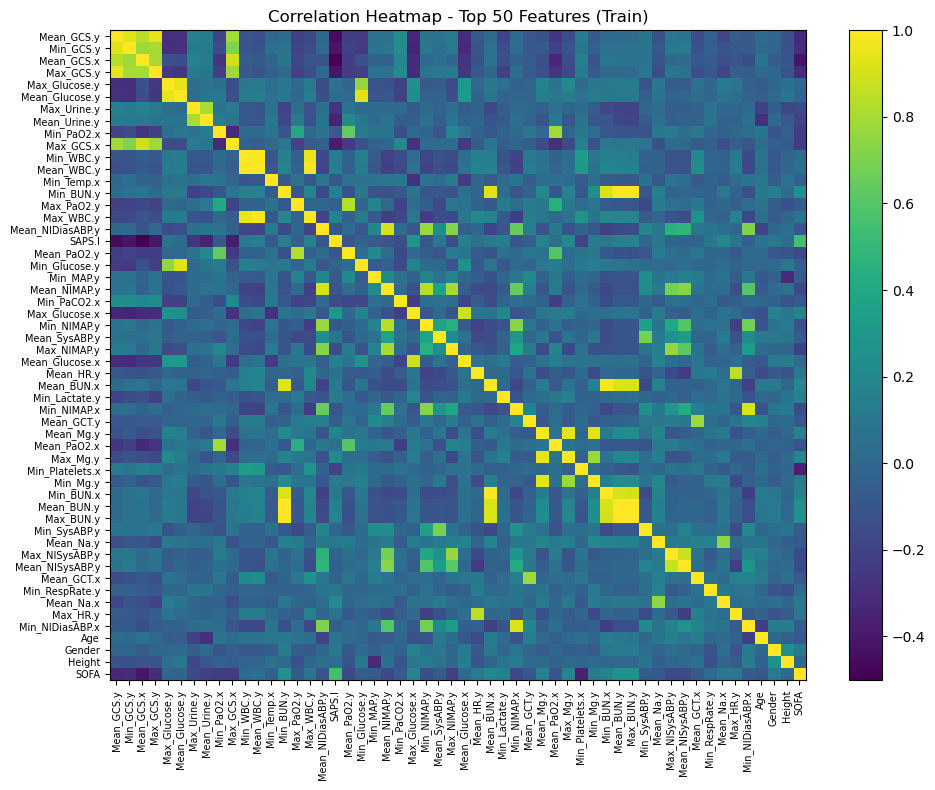

In [11]:
# 2.2 Correlation heatmap (Top-50)
corr = X_train_top50.corr()
plt.figure(figsize=(10,8))
plt.imshow(corr.values, aspect='auto')
plt.colorbar()
plt.title("Correlation Heatmap - Top 50 Features (Train)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=7)
plt.tight_layout()
plt.show()


In [13]:
# 2.3 VIF on a manageable subset (e.g., RFE-20) to detect multicollinearity
vif_cols = selected_20 if len(selected_20) > 0 else top50_features[:20]
vif_df = compute_vif(X_train[vif_cols])
vif_df


,feature,VIF
13,Mean_BUN.x,96.198098
15,Min_BUN.x,88.505465
0,Mean_GCS.y,46.559395
3,Max_GCS.y,18.467548
1,Min_GCS.y,12.773884
16,Max_NISysABP.y,8.316088
2,Mean_GCS.x,8.262273
8,Min_BUN.y,7.867596
17,Mean_NISysABP.y,7.265477
6,Max_GCS.x,5.684086


In [17]:
# 3.1 Build pipelines
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced", solver="liblinear"))
])

pipe_rf2 = Pipeline([
    ("scaler", StandardScaler()),  # harmless for RF, keeps interface consistent
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
])

# 3.2 Hyperparameter grids
param_lr = {
    "clf__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "clf__penalty": ["l2"],  # 'l1' possible with liblinear, add if needed
}

param_rf = {
    "clf__n_estimators": [200, 400, 800],
    "clf__max_depth": [None, 6, 12],
    "clf__min_samples_leaf": [1, 2, 4],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 3.3 Train on a chosen feature set (use RFE-20 by default; fallback to Top-50)
model_cols = vif_cols
Xtr, Xte = X_train[model_cols], X_test[model_cols]

gs_lr = GridSearchCV(pipe_lr, param_grid=param_lr, scoring="roc_auc", cv=cv, n_jobs=-1)
gs_lr.fit(Xtr, y_train)

gs_rf = GridSearchCV(pipe_rf2, param_grid=param_rf, scoring="roc_auc", cv=cv, n_jobs=-1)
gs_rf.fit(Xtr, y_train)

print("Best LR params:", gs_lr.best_params_, "AUC:", gs_lr.best_score_)
print("Best RF params:", gs_rf.best_params_, "AUC:", gs_rf.best_score_)


Best LR params: {'clf__C': 0.01, 'clf__penalty': 'l2'} AUC: 0.8096101429434762
Best RF params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 200} AUC: 0.8159445492778825



=== Logistic Regression on TEST ===
Accuracy: 0.650 Precision: 0.612 Recall: 0.638 F1: 0.625 AUC: 0.746
Confusion Matrix:
 [[37 19]
 [17 30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.67        56
           1       0.61      0.64      0.62        47

    accuracy                           0.65       103
   macro avg       0.65      0.65      0.65       103
weighted avg       0.65      0.65      0.65       103


=== Random Forest on TEST ===
Accuracy: 0.689 Precision: 0.660 Recall: 0.660 F1: 0.660 AUC: 0.782
Confusion Matrix:
 [[40 16]
 [16 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        56
           1       0.66      0.66      0.66        47

    accuracy                           0.69       103
   macro avg       0.69      0.69      0.69       103
weighted avg       0.69      0.69      0.69       103



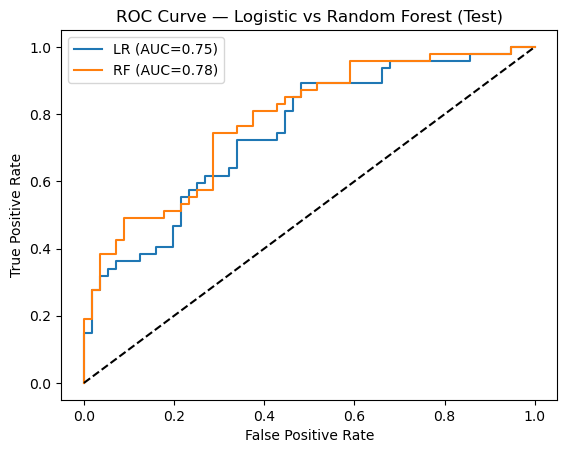

In [19]:
# 3.4 Evaluate on hold-out test
best_lr = gs_lr.best_estimator_
best_rf = gs_rf.best_estimator_

# Predictions
y_pred_lr = best_lr.predict(Xte)
y_prob_lr = best_lr.predict_proba(Xte)[:,1]

y_pred_rf = best_rf.predict(Xte)
y_prob_rf = best_rf.predict_proba(Xte)[:,1]

def eval_report(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n=== {name} on TEST ===")
    print("Accuracy:", f"{acc:.3f}", "Precision:", f"{prec:.3f}", "Recall:", f"{rec:.3f}", "F1:", f"{f1:.3f}", "AUC:", f"{auc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

eval_report("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
eval_report("Random Forest", y_test, y_pred_rf, y_prob_rf)

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_score(y_test, y_prob_lr):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_score(y_test, y_prob_rf):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic vs Random Forest (Test)")
plt.legend(); plt.show()


In [21]:
# Get the trained scaler & LR coef from the best pipeline
std_scaler = best_lr.named_steps["scaler"]
lr_clf     = best_lr.named_steps["clf"]

coef = pd.Series(lr_clf.coef_[0], index=model_cols)
scales = pd.Series(std_scaler.scale_, index=model_cols)  # standard deviations per feature
means = pd.Series(std_scaler.mean_, index=model_cols)

def odds_ratio_for_delta(feature_name: str, delta: float) -> float:
    if feature_name not in coef.index:
        raise ValueError(f"{feature_name} not in model features.")
    beta = coef[feature_name]
    scale = scales[feature_name]
    return float(np.exp(beta * (delta / scale)))

# Example: effect of a 10-unit DROP in systolic BP (find the column name you used, e.g., 'SysABP' or 'Mean_SysABP.x')
candidate_bp_cols = [c for c in model_cols if normalized_base(c).lower() == "sysabp"]
if candidate_bp_cols:
    bp_col = candidate_bp_cols[0]
    OR_drop10 = odds_ratio_for_delta(bp_col, delta=-10)  # drop by 10
    print(f"For {bp_col}: a 10-unit DROP corresponds to OR={OR_drop10:.3f} ( {(OR_drop10-1)*100:+.1f}% change in odds)")
else:
    print("No SysABP-like feature in the selected model. Adjust candidate_bp_cols logic if needed.")


No SysABP-like feature in the selected model. Adjust candidate_bp_cols logic if needed.


In [23]:
# Choose the better test AUC model for risk (LR or RF)
auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_rf = roc_auc_score(y_test, y_prob_rf)
best_name = "RF" if auc_rf >= auc_lr else "LR"

y_prob_best = y_prob_rf if best_name == "RF" else y_prob_lr

# Risk cutoffs (tunable): Low < 0.33, Medium 0.33–0.66, High > 0.66
bins = [0.0, 0.33, 0.66, 1.0]
labels = ["Low", "Medium", "High"]
risk_cat = pd.cut(y_prob_best, bins=bins, labels=labels, include_lowest=True)

risk_df = pd.DataFrame({
    "y_true": y_test.values,
    "prob": y_prob_best,
    "risk": risk_cat
})
print(risk_df.head())
print("\nRisk distribution:\n", risk_df["risk"].value_counts())

# Optional: evaluate recall for High-risk bucket
high_mask = (risk_df["risk"] == "High")
recall_high_bucket = risk_df.loc[high_mask, "y_true"].mean() if high_mask.sum() > 0 else np.nan
print(f"\nShare of deaths within 'High' bucket: {recall_high_bucket:.3f} (higher is better)")


   y_true      prob    risk
0       1  0.700209    High
1       1  0.668747    High
2       1  0.308743     Low
3       0  0.530960  Medium
4       0  0.391404  Medium

Risk distribution:
 risk
Medium    46
Low       30
High      27
Name: count, dtype: int64

Share of deaths within 'High' bucket: 0.815 (higher is better)


In [25]:
# Pick a small set of clinically sensible features (replace with your chosen columns if needed)
simple_cols = []
for base in ["GCS", "HR", "Lactate", "Glucose", "SysABP", "BUN"]:
    # find any available column for that base among training columns
    cands = [c for c in X_train.columns if normalized_base(c).lower() == base.lower()]
    if cands:
        simple_cols.append(cands[0])

simple_cols = list(dict.fromkeys([c for c in simple_cols if c in X_train.columns]))  # unique & valid
print("Simple categorical system features:", simple_cols)

def bin_series(s: pd.Series, q=[0.33, 0.66], labels=("Low","Mid","High")):
    return pd.qcut(s.rank(method="first"), q=[0]+q+[1], labels=labels)

Xtr_simple = X_train[simple_cols].apply(bin_series)
Xte_simple = X_test[simple_cols].apply(lambda col: pd.qcut(
    col.rank(method="first"), q=[0,0.33,0.66,1], labels=("Low","Mid","High"), duplicates="drop"
))

# One-hot encode categories
Xtr_simple_dum = pd.get_dummies(Xtr_simple, drop_first=True)
Xte_simple_dum = pd.get_dummies(Xte_simple, drop_first=True)
Xtr_simple_dum, Xte_simple_dum = Xtr_simple_dum.align(Xte_simple_dum, join="left", axis=1, fill_value=0)

# Simple logistic regression
pipe_simple_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # sparse-safe
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
])
pipe_simple_lr.fit(Xtr_simple_dum, y_train)
y_pred_simple = pipe_simple_lr.predict(Xte_simple_dum)
y_prob_simple = pipe_simple_lr.predict_proba(Xte_simple_dum)[:,1]

eval_report("Simple Categorical System (LR)", y_test, y_pred_simple, y_prob_simple)


Simple categorical system features: ['Mean_GCS.x', 'Mean_HR.x', 'Mean_Lactate.x', 'Mean_Glucose.x', 'Mean_SysABP.x', 'Mean_BUN.x']

=== Simple Categorical System (LR) on TEST ===
Accuracy: 0.709 Precision: 0.689 Recall: 0.660 F1: 0.674 AUC: 0.733
Confusion Matrix:
 [[42 14]
 [16 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.74        56
           1       0.69      0.66      0.67        47

    accuracy                           0.71       103
   macro avg       0.71      0.70      0.71       103
weighted avg       0.71      0.71      0.71       103

